In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [11]:
# Define selection for query 
sel = [Measurement.date,
       Measurement.prcp]

In [12]:
# Calculate the date 1 year ago from today
# find last date in set
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
end_date

('2017-08-23')

In [13]:
# 12 months before last date
start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
start_date

datetime.date(2016, 8, 23)

<IPython.core.display.Javascript object>


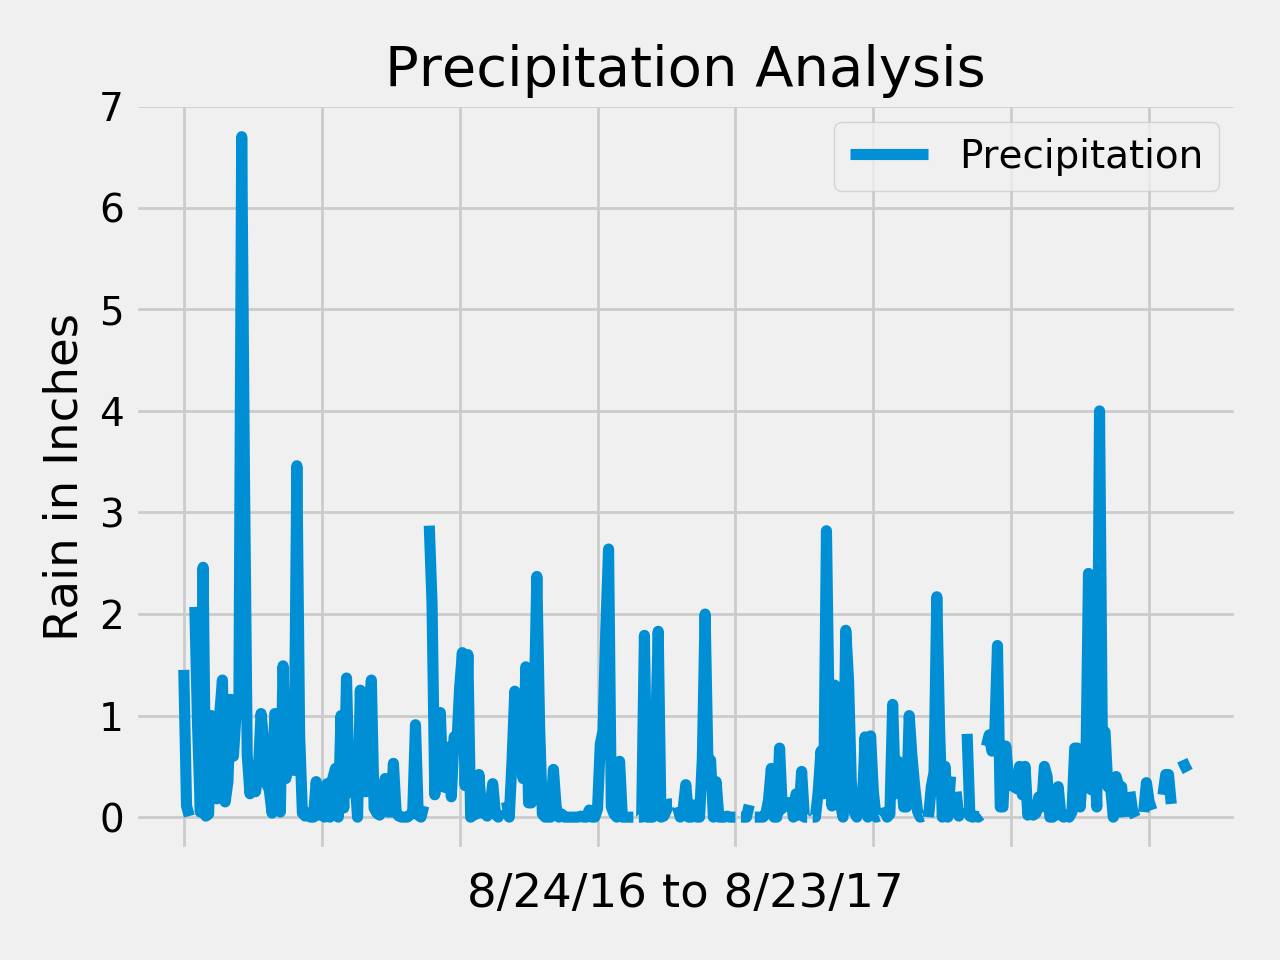

In [14]:
# Perform a query to retrieve the data and precipitation scores
prcp_results = session.query(*sel).\
    filter(Measurement.date > start_date).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(prcp_results, columns=['date', 'prcp'])
df.set_index('date', inplace=True)
ax = df.plot()

# Use Pandas Plotting with Matplotlib to plot the data
plt.xlabel("8/24/16 to 8/23/17")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis")
plt.legend(["Precipitation"])

# Rotate the xticks for the dates
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,344.000000
mean,0.431308
std,0.705240
min,0.000000
25%,0.010000
50%,0.140000
75%,0.565000
max,6.700000


In [16]:
# How many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [17]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature most active station?
most_active = active_stations[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

[(54.0, 71.66378066378067, 85.0)]

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
# and plot the results as a histogram
temp_results = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date >= start_date).all()
temp_df = pd.DataFrame(temp_results)
temp_df.set_index('station', inplace=True)
temp_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


<IPython.core.display.Javascript object>


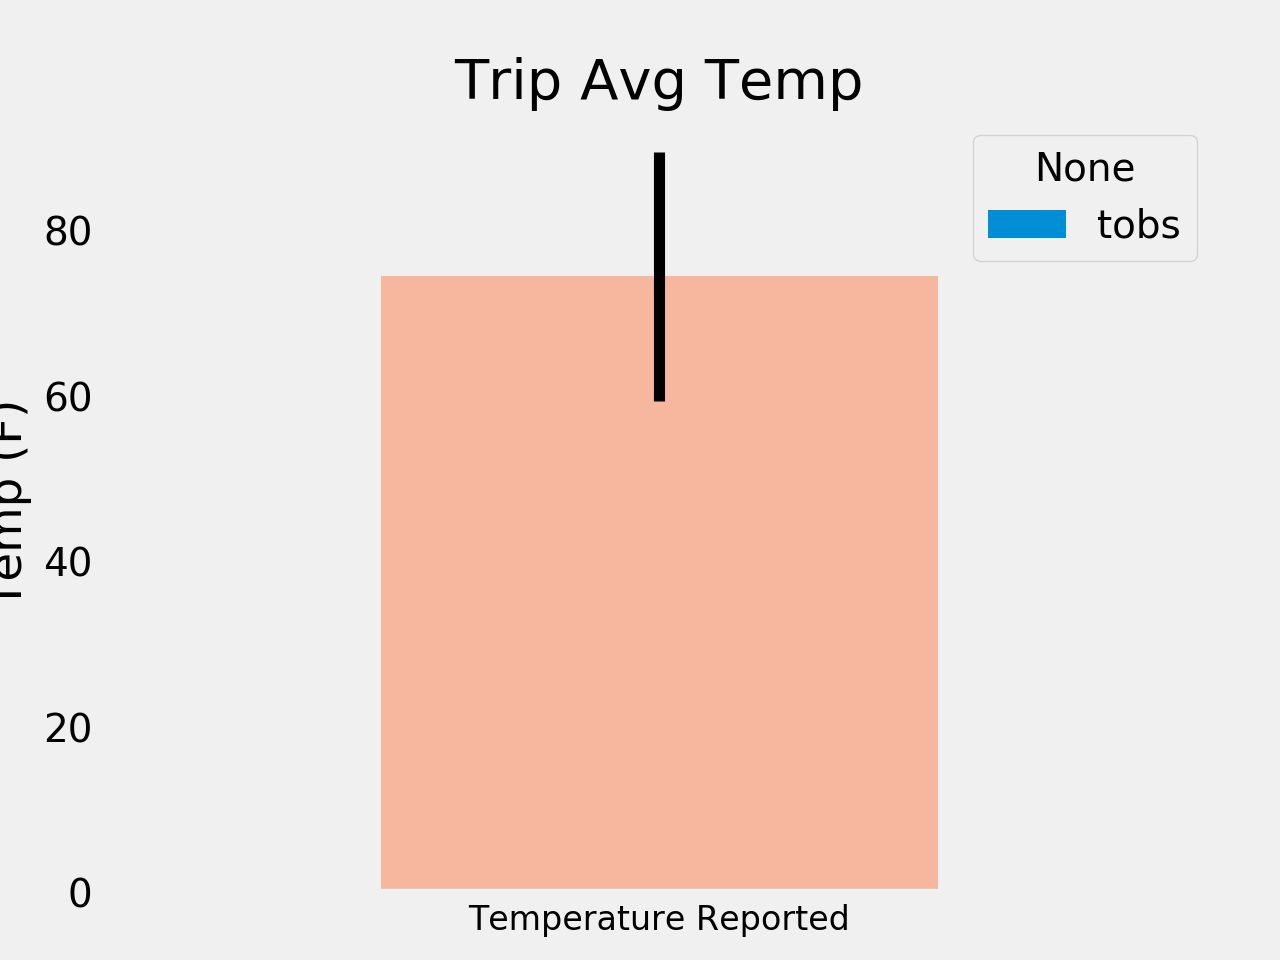

<function matplotlib.pyplot.show(*args, **kw)>

In [20]:
temp_df.plot.hist(by='station', bins=12)
plt.grid()
plt.title("Temperature Observations for Station " + most_active, fontsize=15)
plt.xlabel("Temperature Reported", fontsize=12)
plt.legend(bbox_to_anchor=(1,1), fontsize=12)
plt.show

In [21]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2017-04-01'
trip_end = '2017-04-15'
trip_temps_LY = calc_temps(trip_start, trip_end)
trip_temps_LY

[(67.0, 74.47368421052632, 82.0)]

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_df = pd.DataFrame(trip_temps_LY, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, alpha=0.5, color='coral')
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.show()